## LearnX Time Series (Advanced ML Hackathon)

https://datahack.analyticsvidhya.com/contest/ascend-pro-assessment-advanced-ml/#LeaderBoard

LearnX is an online learning platform aimed at professionals and students. LearnX serves as a market place that allows instructors to build online courses on topics of their expertise which is later published after due diligence by the LearnX team. The platform covers a wide variety of topics including Development, Business, Finance & Accounting & Software Marketing and so on

Effective forecasting for course sales gives essential insight into upcoming cash flow meaning business can more accurately plan the budget to pay instructors and other operational costs and invest in the expansion of the business.

Sales data for more than 2 years from 600 courses of LearnX's top domains is available along with information on

Competition in the market for each course
Course Type (Course/Program/Degree)
Holiday Information for each day
User Traffic on Course Page for each day
Your task is to predict the course sales for each course in the test set for the next 60 days

In [713]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import time

from sklearn.metrics import mean_squared_error
from math import sqrt
from statistics import mean 

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from datetime import date, timedelta
from sklearn.model_selection import GridSearchCV,StratifiedKFold
# models for ML time series techniques.
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [645]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test_syuMJMz.csv")

In [646]:
print(train.shape)
train.head()

(512087, 11)


,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
0,1,1,1,Development,Course,0,1,1,11004,0.007,81
1,2,2,1,Development,Course,0,0,1,13650,0.007,79
2,3,3,1,Development,Course,0,0,1,11655,0.007,75
3,4,4,1,Development,Course,0,0,1,12054,0.007,80
4,5,5,1,Development,Course,0,0,1,6804,0.007,41


In [647]:
train.tail()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
512082,548023,878,600,Software Marketing,Program,0,0,1,8904,0.07,114
512083,548024,879,600,Software Marketing,Program,0,0,1,10542,0.07,145
512084,548025,880,600,Software Marketing,Program,0,0,1,13671,0.07,167
512085,548026,881,600,Software Marketing,Program,0,0,1,8904,0.07,107
512086,548027,882,600,Software Marketing,Program,1,0,1,11445,0.07,152


In [648]:
train.describe()

,ID,Day_No,Course_ID,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
count,512087.000000,512087.000000,512087.000000,512087.000000,512087.000000,512087.000000,512087.000000,510323.000000,512087.000000
mean,274007.300650,434.917869,300.388344,0.380244,0.031639,0.488968,15375.101198,0.073345,120.826924
std,158228.834029,256.044161,173.365787,0.485447,0.175038,0.499879,7727.231205,0.100115,54.355258
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000
25%,136962.500000,214.000000,150.000000,0.000000,0.000000,0.000000,10584.000000,0.010000,84.000000
50%,273984.000000,427.000000,300.000000,0.000000,0.000000,0.000000,13776.000000,0.035000,111.000000
75%,411065.500000,658.000000,451.000000,1.000000,0.000000,1.000000,18123.000000,0.094000,146.000000
max,548027.000000,882.000000,600.000000,1.000000,1.000000,1.000000,100002.000000,0.768000,682.000000


In [649]:
list(train.columns)

['ID',
 'Day_No',
 'Course_ID',
 'Course_Domain',
 'Course_Type',
 'Short_Promotion',
 'Public_Holiday',
 'Long_Promotion',
 'User_Traffic',
 'Competition_Metric',
 'Sales']

In [650]:
list(test.columns)

['ID',
 'Day_No',
 'Course_ID',
 'Course_Domain',
 'Course_Type',
 'Short_Promotion',
 'Public_Holiday',
 'Long_Promotion',
 'Competition_Metric']

In [651]:
set(train.columns) - set(test.columns)

{'Sales', 'User_Traffic'}

Note that 'User_Traffic' is not apart of the test set. Expected that target 'Sales' is not apart of the test set. Should we just drop it?

In [652]:
train = train.drop(['User_Traffic'], axis=1)

In [653]:
train.isna().sum() # mostly missing values for 'Competition_Metric' 

ID                       0
Day_No                   0
Course_ID                0
Course_Domain            0
Course_Type              0
Short_Promotion          0
Public_Holiday           0
Long_Promotion           0
Competition_Metric    1764
Sales                    0
dtype: int64

We will fill the above missing values with the median

In [654]:
train.fillna(train['Competition_Metric'].median(),inplace=True)

In [655]:
train.isna().sum() # double checking if NaN were filled

ID                    0
Day_No                0
Course_ID             0
Course_Domain         0
Course_Type           0
Short_Promotion       0
Public_Holiday        0
Long_Promotion        0
Competition_Metric    0
Sales                 0
dtype: int64

In [656]:
train['Course_ID'].value_counts() # some courses have 882 days and others have 698 days of data.

361    882
326    882
584    882
328    882
72     882
      ... 
407    698
592    698
78     698
551    698
511    698
Name: Course_ID, Length: 600, dtype: int64

In [657]:
test.isnull().sum()

ID                      0
Day_No                  0
Course_ID               0
Course_Domain           0
Course_Type             0
Short_Promotion         0
Public_Holiday          0
Long_Promotion          0
Competition_Metric    120
dtype: int64

In [658]:
test.fillna(test['Competition_Metric'].median(),inplace=True)

Note, some courses have 882 days and some 698 days.

## Exploratory Data Analysis (EDA)
### Univarite

<AxesSubplot:xlabel='Sales'>

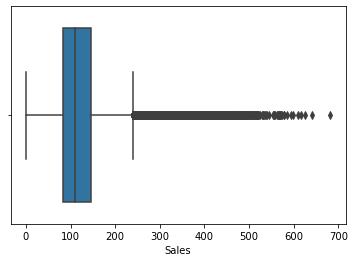

In [659]:
sns.boxplot(x=train['Sales'])

<AxesSubplot:xlabel='Sales', ylabel='Density'>

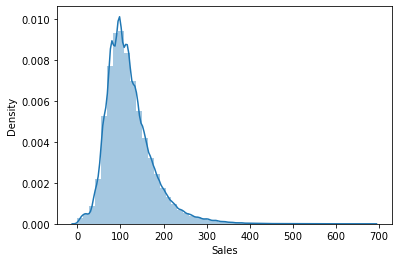

In [660]:
sns.distplot(train['Sales'])

From the above, we can see there the distribution is right skewed, i.e. there are quite a few high sales numbers. We will log transform this later to make it more normally distributed - may help with ML approaches, i.e. other than Holt's winter and ARIMA.

<AxesSubplot:xlabel='Day_No', ylabel='Density'>

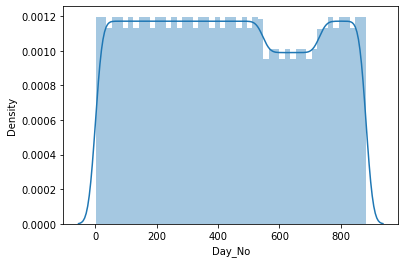

In [661]:
sns.distplot(train['Day_No'])

<AxesSubplot:xlabel='Competition_Metric', ylabel='Density'>

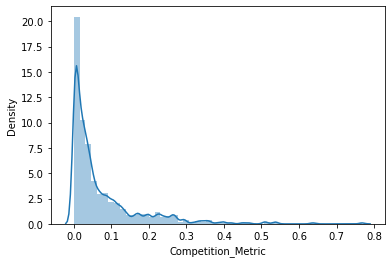

In [662]:
sns.distplot(train['Competition_Metric'])

0    495885
1     16202
Name: Public_Holiday, dtype: int64


<AxesSubplot:xlabel='Public_Holiday', ylabel='count'>

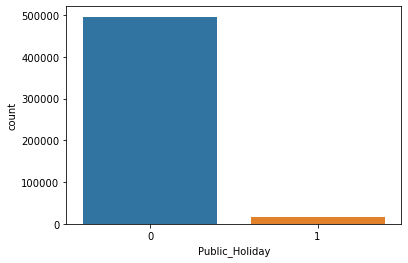

In [663]:
print(train['Public_Holiday'].value_counts())
sns.countplot(train['Public_Holiday'])

0    261693
1    250394
Name: Long_Promotion, dtype: int64


<AxesSubplot:xlabel='Long_Promotion', ylabel='count'>

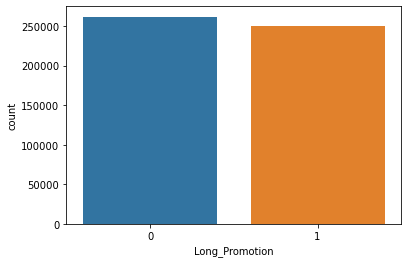

In [664]:
print(train['Long_Promotion'].value_counts())
sns.countplot(train['Long_Promotion'])

Looks somewhat stationary...but definitely not 'strict Stationary', more like 'trend stationary'.
We will use some statistical tests to check for stationarity.

<AxesSubplot:xlabel='Short_Promotion', ylabel='count'>

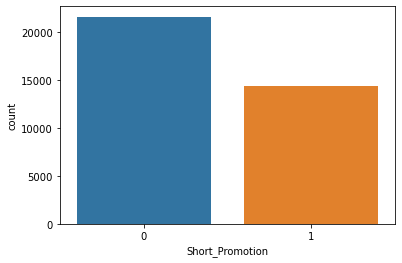

In [665]:
sns.countplot(test['Short_Promotion']) 

<AxesSubplot:xlabel='Course_Domain', ylabel='count'>

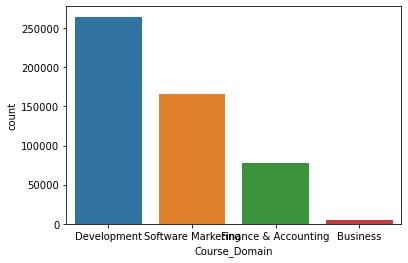

In [666]:
sns.countplot(train['Course_Domain'])

<AxesSubplot:xlabel='Course_Type', ylabel='count'>

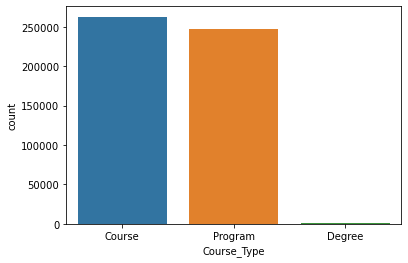

In [667]:
sns.countplot(train['Course_Type'])

<AxesSubplot:ylabel='Sales'>

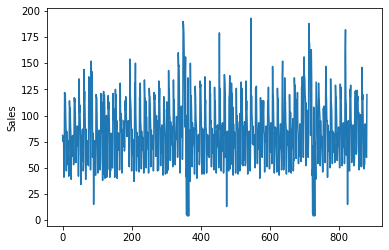

In [668]:
sns.lineplot(data=train[train['Course_ID'] == 1]['Sales'])

Above time series plot is for course ID equal to 1 for 882 days.

<AxesSubplot:ylabel='Sales'>

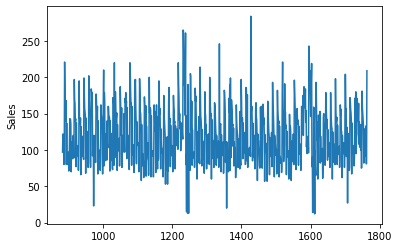

In [669]:
sns.lineplot(data=train[train['Course_ID'] == 2]['Sales'])

<AxesSubplot:ylabel='Sales'>

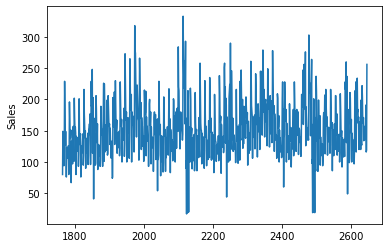

In [670]:
sns.lineplot(data=train[train['Course_ID'] == 3]['Sales'])

It looks like each course ID and its duration is cascaded in series to the day count! A bit confusing at first, but essentially we are predicting the next 60 days for 600 courses, which accounts for the shape of the test set being 3600.

## Trend and Seasonality

In [671]:
import statsmodels.api as sm
train.columns

Index(['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
       'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
       'Competition_Metric', 'Sales'],
      dtype='object')

In [672]:
# sm.tsa.seasonal_decompose(train['Sales']).plot()

In [673]:
# above doesnt quite work because it needs the index of the train df to be datetime objects, here we just have day numbers

## Feature Engineering

Note, we had two categorical features, namely 'Course_domain' and 'Course_Type'. We will use pd get_dummies to turn them into dummy variables/indicators.

In [674]:
train = pd.get_dummies(train, columns=['Course_Domain','Course_Type'], drop_first=True)

In [675]:
test = pd.get_dummies(test ,columns=['Course_Domain','Course_Type'], drop_first=True)

In [676]:
train.head()

,ID,Day_No,Course_ID,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Sales,Course_Domain_Development,Course_Domain_Finance & Accounting,Course_Domain_Software Marketing,Course_Type_Degree,Course_Type_Program
0,1,1,1,0,1,1,0.007,81,1,0,0,0,0
1,2,2,1,0,0,1,0.007,79,1,0,0,0,0
2,3,3,1,0,0,1,0.007,75,1,0,0,0,0
3,4,4,1,0,0,1,0.007,80,1,0,0,0,0
4,5,5,1,0,0,1,0.007,41,1,0,0,0,0


We will also add some day, month, and year features for the models to learn, rather then depending on 'Day_No' alone. Trend and Seasonality may not be able to be acquired clearly without further temporal features.

In [677]:
def day_to_date(dataset):
    start = date(2019,12,31) # arbritrarily set to 2019 (as long as two year window)
    dataset['Date'] = dataset['Day_No'].apply(lambda x: start + timedelta(x)) 

def day_month_year(dataset): 
    dataset['Day'] = dataset['Date'].apply(lambda x: x.day)
    dataset['Month'] = dataset['Date'].apply(lambda x: x.month)
    dataset['Year'] = dataset['Date'].apply(lambda x: x.year)

In [678]:
# add datetime features to both train and test sets
day_to_date(train)
day_to_date(test)
day_month_year(train)
day_month_year(test)

In [679]:
# specific format for ARIMA
train_arima = pd.DataFrame()
train_arima = train # includes the 'Date' obj

# specific format for facebook dataframe
train_prophet = pd.DataFrame()
train_prophet['ds'] = train['Date']
train_prophet['y'] = train['Sales']
# remaining models
train = train.drop(['Date'], axis=1)
test = test.drop(['Date'], axis=1)


In [680]:
train.columns

Index(['ID', 'Day_No', 'Course_ID', 'Short_Promotion', 'Public_Holiday',
       'Long_Promotion', 'Competition_Metric', 'Sales',
       'Course_Domain_Development', 'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program', 'Day', 'Month', 'Year'],
      dtype='object')

In [681]:
test.columns

Index(['ID', 'Day_No', 'Course_ID', 'Short_Promotion', 'Public_Holiday',
       'Long_Promotion', 'Competition_Metric', 'Course_Domain_Development',
       'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program', 'Day', 'Month', 'Year'],
      dtype='object')

In [698]:
train.head()

,ID,Day_No,Course_ID,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Sales,Course_Domain_Development,Course_Domain_Finance & Accounting,Course_Domain_Software Marketing,Course_Type_Degree,Course_Type_Program,Day,Month,Year
0,1,1,1,0,1,1,0.007,81,1,0,0,0,0,1,1,2020
1,2,2,1,0,0,1,0.007,79,1,0,0,0,0,2,1,2020
2,3,3,1,0,0,1,0.007,75,1,0,0,0,0,3,1,2020
3,4,4,1,0,0,1,0.007,80,1,0,0,0,0,4,1,2020
4,5,5,1,0,0,1,0.007,41,1,0,0,0,0,5,1,2020


# Time Series Forecasting Techniques
**We will explore some of the various statistical and ML methods below.**

Statistical Methods
* Naive Method (skip)
* Simple Average (skip)
* Moving Average (skip)
* Simple Exponential Smoothing (skip)
* Holt's Winter
* ARIMA (autoregressive)
* Facebook's Prophet

Machine Learning Methods
* RandomForest (ensemble)
* KNN
* XGBoost
* LGMBoost

We will skip and go straight to Holt's Winter for exponential smoothing, then explore ARIMA before looking into ML methods, i.e. XGBoost

In [682]:
test.tail()

,ID,Day_No,Course_ID,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Course_Domain_Development,Course_Domain_Finance & Accounting,Course_Domain_Software Marketing,Course_Type_Degree,Course_Type_Program,Day,Month,Year
35995,548083,938,600,1,0,1,0.07,0,0,1,0,1,26,7,2022
35996,548084,939,600,1,0,1,0.07,0,0,1,0,1,27,7,2022
35997,548085,940,600,1,0,1,0.07,0,0,1,0,1,28,7,2022
35998,548086,941,600,1,0,1,0.07,0,0,1,0,1,29,7,2022
35999,548087,942,600,1,0,1,0.07,0,0,1,0,1,30,7,2022


## Cost Function 
Specified by Hackathon specs to use RMS log to not be as senstive to outliers

In [683]:
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y_true + 1) - np.log1p(y_pred + 1), 2))) *1000

In [684]:
train.shape, test.shape

((512087, 16), (36000, 15))

## Time Series Cross Validation
We need to be careful not to shuffle the training data because its' time sensitive, use **TimeSeriesSplit** instead of train_test_split from sklearn

In [685]:
from sklearn.model_selection import TimeSeriesSplit

In [686]:
time_series_cv = TimeSeriesSplit(n_splits=5)
print(time_series_cv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [687]:
for i, (train_index, test_index) in enumerate(time_series_cv.split(train)):
    print(f'----- Fold:{i} ----')
    print("TRAIN:", train_index[0], 'to', train_index[-1])
    print("TEST:", test_index[0], 'to', test_index[-1])

----- Fold:0 ----
TRAIN: 0 to 85351
TEST: 85352 to 170698
----- Fold:1 ----
TRAIN: 0 to 170698
TEST: 170699 to 256045
----- Fold:2 ----
TRAIN: 0 to 256045
TEST: 256046 to 341392
----- Fold:3 ----
TRAIN: 0 to 341392
TEST: 341393 to 426739
----- Fold:4 ----
TRAIN: 0 to 426739
TEST: 426740 to 512086


# Holt's Winters (aka triple exponential smoothing)
Takes level, trend, and seasonality into account.

In [480]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
model = Holt(np.asarray(y_train)).fit(smoothing_level = 0.3,smoothing_slope = 0.1)

In [708]:
# holt winter model training and cv.

cv_score =[]
for i, (train_index, test_index) in enumerate(time_series_cv.split(train)):
    print(f'CV: {i + 1} ')
    # import pdb; pdb.set_trace()
    x_train, x_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    # import pdb; pdb.set_trace()
    #model
    model = Holt(np.asarray(y_train)).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
    y_pred= model.forecast(len(x_test))
    score = rmsle(y_test, y_pred)
    print(f'RMSLE score:{score}')
    cv_score.append(score)


CV: 1 
RMSLE score:1599.6265141135643
CV: 2 
RMSLE score:1021.4837490064173
CV: 3 
RMSLE score:1486.9987431854859
CV: 4 
RMSLE score:5643.17491860777
CV: 5 
RMSLE score:5548.376537140865


In [350]:
print(f'Average Cross Validation RMSLE: {np.mean(cv_score)}')

Average Cross Validation RMSLE: 3059.9320924108206


## Visualize Forecast
* We will plot per course ID (several) and append 60 day forecast 
* Separate for 2 colors for ease of interpretation

In [709]:
import time
start = time.time()
holt_winter = Holt(np.asarray(y)).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
holt_winter_pred= model.forecast(len(test))
end = time.time()
print(f'Train and inference duration: {(end - start) / 60} min.')

Train and inference duration: 0.10694734652837118 min.


In [710]:
len(holt_winter_pred)

36000

In [711]:
holt_winter_preds_chunks = np.array_split(holt_winter_pred, 600) # split into chunks of 60 day predictions for viz

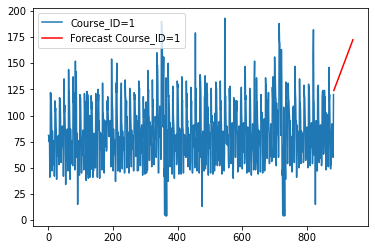

In [712]:
# utility ploting function for prediction viz (in red)
def viz_pred(course_id, preds):
    plt.plot(train[train['Course_ID'] == course_id]['Day_No'], train[train['Course_ID'] == course_id]['Sales'], label=f'Course_ID={course_id}')
    plt.plot(test[test['Course_ID'] == course_id]['Day_No'], preds[course_id - 1], label=f'Forecast Course_ID={course_id}', color='red')
    plt.legend(loc='best')
    plt.show()
viz_pred(1, holt_winter_preds_chunks)

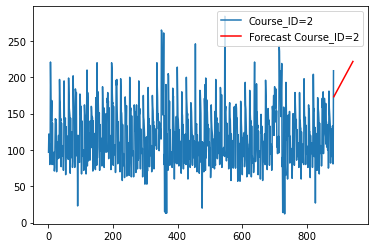

In [355]:
viz_pred(2, holt_winter_preds_chunks)

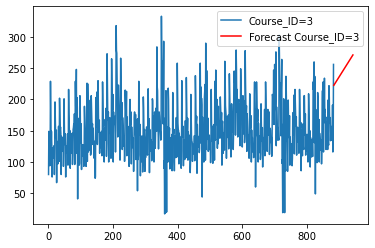

In [699]:
viz_pred(3, holt_winter_preds_chunks)

From the above, we can clearly see the next 60 days prediction does increase, but does not capture the various pertubations of the time series as well. Let's try ARIMA.

## ARIMA
AutoRgressor, reference here: https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/

In [ ]:
train_arima.head()

In [481]:
# arima_model = sm.tsa.statespace.SARIMAX(train_arima.Sales, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
# arima_pred = arima_model.predict(start="2019-11-1", end="2021-12-31", dynamic=True)

# Prophet
Facebook's decomposable (tren + seasonality + holidays) models.
Great read here: https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/

In [374]:
# uncomment below to install if already not in your system
# ! pip install pystan==2.19.1.1
# ! pip install fbprophet

In [375]:
from fbprophet import Prophet

In [416]:
fb_model = Prophet()
fb_model.fit(train_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [417]:
future = fb_model.make_future_dataframe(periods=60)

In [418]:
future.tail()

,ds
937,2022-07-26
938,2022-07-27
939,2022-07-28
940,2022-07-29
941,2022-07-30


In [419]:
prophet_pred = fb_model.predict(future)

In [420]:
len(prophet_pred)

942

In [356]:
# uncomment below if you dont have the packages installed.
# !pip install xgboost
# !pip install lightgbm
# !brew install libomp

## Machine Learning Techcniques
Next we will use some ML techniques for forecasting to see if it's better than the above statistical methods.

In [689]:
train.dtypes

ID                                      int64
Day_No                                  int64
Course_ID                               int64
Short_Promotion                         int64
Public_Holiday                          int64
Long_Promotion                          int64
Competition_Metric                    float64
Sales                                   int64
Course_Domain_Development               uint8
Course_Domain_Finance & Accounting      uint8
Course_Domain_Software Marketing        uint8
Course_Type_Degree                      uint8
Course_Type_Program                     uint8
Day                                     int64
Month                                   int64
Year                                    int64
dtype: object

# Random Forest

In [739]:
X = train.drop(['Sales'], axis=1)
y = train['Sales']

In [ ]:
# random forest training
cv_score =[]
for i, (train_index, test_index) in enumerate(time_series_cv.split(train)):
    print(f'CV: {i + 1} ')
    # import pdb; pdb.set_trace()
    x_train, x_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    #model
    rf = RandomForestRegressor(n_estimators=400)
    rf.fit(x_train, y_train)
    y_pred= rf.predict(x_test)
    score = rmsle(y_test, y_pred)
    print(f'RMSLE score:{score}')
    cv_score.append(score)  

In [740]:
import time
start = time.time()
model = RandomForestRegressor(n_estimators=400)
model.fit(X, y)
rf_preds = model.predict(test)
end = time.time()
print(f'Train and inference duration: {(end - start) / 60} min.')

Train and inference duration: 15.440021673838297 min.


In [741]:
rf_preds_chunks = np.array_split(rf_preds, 600) # 60 day forecast chunks, broken up into chunks

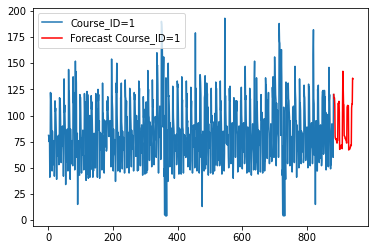

In [742]:
viz_pred(1, rf_preds_chunks) # predictions for course 1

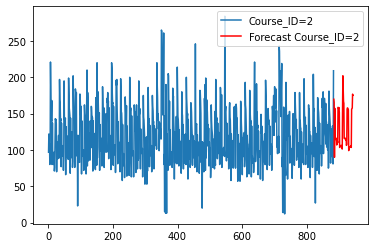

In [743]:
viz_pred(2, rf_preds_chunks) # predictions for course 2

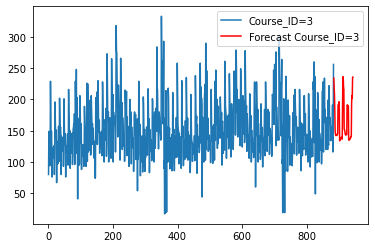

In [744]:
viz_pred(3, rf_preds_chunks) # predictions for course 3

# XGBoost
Estimators in series that correct the errors of the previous models.
Nice read and motivation for using XGBoost: https://towardsdatascience.com/5-machine-learning-techniques-for-sales-forecasting-598e4984b109

In [694]:
X = train.drop(['Sales'], axis=1)
y = train['Sales']

In [691]:
# xgboost training
cv_score =[]
for i, (train_index, test_index) in enumerate(time_series_cv.split(train)):
    print(f'CV: {i + 1} ')
    # import pdb; pdb.set_trace()
    x_train, x_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    #model
    xgb = XGBRegressor(n_estimators=400)
    xgb.fit(x_train, y_train)
    y_pred= xgb.predict(x_test)
    score = rmsle(y_test, y_pred)
    print(f'RMSLE score:{score}')
    cv_score.append(score)    
    

CV: 1 
RMSLE score:587.1042447454911
CV: 2 
RMSLE score:570.0463065245538
CV: 3 
RMSLE score:416.3758048966159
CV: 4 
RMSLE score:569.981457902083
CV: 5 
RMSLE score:404.78385690904094


In [692]:
print(f'Average Cross Validation RMSLE: {np.mean(cv_score)}')

Average Cross Validation RMSLE: 509.6583341955569


In [695]:
import time
start = time.time()
xgb = XGBRegressor(n_estimators= 400, learning_rate=0.2)
xgb.fit(X, y)
xgb_preds = xgb.predict(test)
end = time.time()
print(f'Train and inference duration: {(end - start) / 60} min.')

Train and inference duration: 0.9025521993637085 min.


In [623]:
xgb_preds_chunks = np.array_split(xgb_preds, 600) # 60 day forecast chunks, broken up into chunks

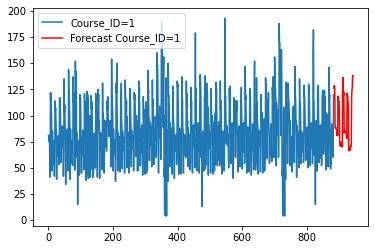

In [624]:
viz_pred(1, xgb_preds_chunks) # predictions for course 1

For course_id 1 - looks pretty decent and reasonable.

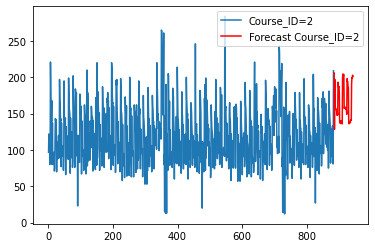

In [625]:
viz_pred(2, xgb_preds_chunks) # predictions for course 2

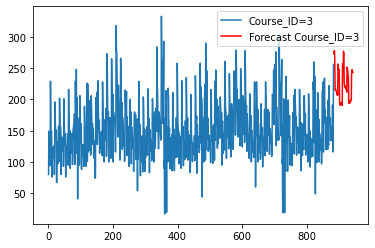

In [626]:
viz_pred(3, xgb_preds_chunks) # predictions for course 3

# LGBM

In [292]:
# lgbm training
cv_score =[]
for i, (train_index, test_index) in enumerate(time_series_cv.split(train)):
    print(f'CV: {i + 1} ')
    # import pdb; pdb.set_trace()
    x_train, x_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    #model
    lgbm = LGBMRegressor(n_estimators= 400 )
    lgbm.fit(x_train, y_train)
    y_pred= lgbm.predict(x_test)
    score = rmsle(y_test, y_pred)
    print(f'RMSLE score:{score}')
    cv_score.append(score)   

Fold: 1 
RMSLE score:425.95739351803843
Fold: 2 
RMSLE score:621.8013709815175
Fold: 3 
RMSLE score:424.19050982670996
Fold: 4 
RMSLE score:506.82787539882565
Fold: 5 
RMSLE score:356.95793150397


In [293]:
print(f'Average Cross Validation RMSLE: {np.mean(cv_score)}')

Average Cross Validation RMSLE: 467.1470162458123


In [294]:
import time
start = time.time()
lgbm = LGBMRegressor(n_estimators= 500)
lgbm.fit(X, y)
lgbm_preds = lgbm.predict(test)
end = time.time()
print(f'Train and inference duration: {(end - start) / 60} min.')

Train and inference duration: 0.04672364791234334 min.


In [295]:
lgbm_preds_chunks = np.array_split(lgbm_preds, 600) # 60 day forecast chunks, broken up into chunks

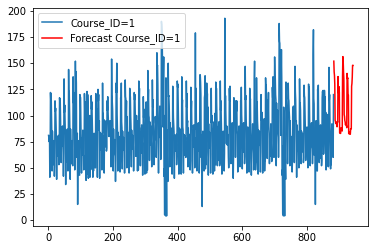

In [296]:
viz_pred(1, lgbm_preds_chunks) # predictions for course 1

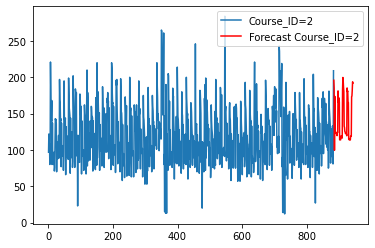

In [297]:
viz_pred(2, lgbm_preds_chunks) # predictions for course 2

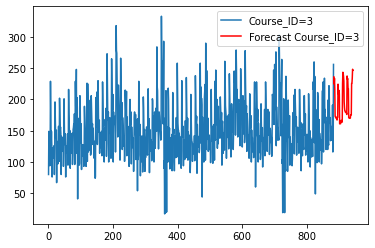

In [298]:
viz_pred(3, lgbm_preds_chunks) # predictions for course 3

## GridSearch to find best hyperparameters for XGBoost and LGBM
We will spend rest of time here to tune since these two models show the most promise and lower RMSLE

In [592]:
from sklearn.model_selection import GridSearchCV

In [593]:
# grid search below

In [746]:
models = [
        {
            "name": "XGBoost",
            "estimator": XGBRegressor(),
            "hyperparameters":
                {
                    "n_estimators": [200, 400, 600]
                }
        },
        {
            "name": "LGBM",
            "estimator": LGBMRegressor(),
            "hyperparameters":
                {
                    "num_leaves": range(10,50,10),
                    "n_estimators": [200, 400, 600],
                    "class_weight": ["balanced", None],
                }
        },
    ]

In [747]:
def select_model(df,features, modles):
    start = time.time()
    X = train.drop(['Sales'], axis=1)
    y = train['Sales']

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))
        start = time.time()
        
        
        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=5)
        grid.fit(X,y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))
        end = time.time()
        print(f'GridSearch Druration: {(end - start) / 60} min.')
    end = time.time()
    print(f'Completed GridSearch: {(end - start) / 60} min.')
    return models

In [595]:
cols = list(train.columns)
cols

['ID',
 'Day_No',
 'Course_ID',
 'Short_Promotion',
 'Public_Holiday',
 'Long_Promotion',
 'Competition_Metric',
 'Sales',
 'Course_Domain_Development',
 'Course_Domain_Finance & Accounting',
 'Course_Domain_Software Marketing',
 'Course_Type_Degree',
 'Course_Type_Program',
 'Day',
 'Month',
 'Year']

In [596]:
result = select_model(train, cols, models)

XGBoost
-------
Best Score: 0.07372409863970028
Best Parameters: {'n_estimators': 400}

GridSearch Druration: 12.03895263671875 min.
LGBM
----
Best Score: 0.1023539113991766
Best Parameters: {'class_weight': None, 'n_estimators': 600, 'num_leaves': 40}

GridSearch Druration: 4.429185684521993 min.


## Final model building after GridSearch

In [599]:
##########################################################################################

Ok, Brute Force time now, let's just try a bunch of models. 

In [736]:
ml_methods = {
    'xgboost': XGBRegressor(n_estimators= 400),
    'lbgm': LGBMRegressor(n_estimators= 400 ),
    'randomforest': RandomForestRegressor(n_estimators=300),
    'knn': KNeighborsClassifier(n_neighbors=8)
}


In [731]:
def run_cross_val(data, model, name):
    print('=' * 5,  f'Cross Validation for model: {name}', '=' * 5)
    cv_score =[]
    for i, (train_index, test_index) in enumerate(time_series_cv.split(data)):
        print(f'CV Fold: {i + 1} ')
        # import pdb; pdb.set_trace()
        x_train, x_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        model.fit(x_train, y_train)
        y_pred= model.predict(x_test)
        score = rmsle(y_test, y_pred)
        print(f'RMSLE score:{score}')
        cv_score.append(score)
    print(f'Average Cross Validation RMSLE for {name}: {np.mean(cv_score)}')

In [738]:
# Trying out a bunch of models.
for k, v in ml_methods.items():
    run_cross_val(train, v, k)

From the above experimentation - RandomForest classifier seemed to work best with 400 estimators. let's do futher GridSearch

In [750]:
models = [
        {
            "name": "RandomForest",
            "estimator": RandomForestRegressor(random_state = 42, verbose=1),
            "hyperparameters":
                {
                    'bootstrap': [True, False],
                    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                    'max_features': ['auto', 'sqrt'],
                    'min_samples_leaf': [1, 2, 4],
                    'min_samples_split': [2, 5, 10],
                    'n_estimators': [200, 400, 600, 800],
                    
                }
        },
    ]

In [ ]:
result = select_model(train, cols, models) # this takes forever.

RandomForest
------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [734]:
# Final Choice
import time
start = time.time()
# model = RandomForestRegressor(n_estimators=400)
# model.fit(X, y)
# rf_preds = model.predict(test)
end = time.time()
print(f'Train and inference duration: {(end - start) / 60} min.')

Train and inference duration: 9.78709936539332 min.


In [ ]:
##########################################################################################

## Submision
Overall, the statisitcal method, i.e. Holt_winter didnt do as well as the xgb and lgbm ML methods. So, creating submissions for only the ML methods below.

In [745]:
submission = pd.DataFrame()
submission['ID'] = test['ID']
submission['Sales'] = rf_preds
submission.to_csv('random_forest.csv', index=False)
submission.head()

,ID,Sales
0,883,120.1150
1,884,116.5725
2,885,116.8750
3,886,110.0850
4,887,79.8775


In [706]:
submission = pd.DataFrame()
submission['ID'] = test['ID']
submission['Sales'] = xgb_preds
submission.to_csv('xgb.csv', index=False)
submission.head()

,ID,Sales
0,883,124.447472
1,884,122.383118
2,885,119.308434
3,886,104.652740
4,887,74.090904


In [611]:
submission = pd.DataFrame()
submission['ID'] = test['ID']
submission['Sales'] = lgbm_preds
submission.to_csv('lgbm.csv', index=False)
submission.head()

,ID,Sales
0,883,151.924865
1,884,145.960571
2,885,146.146474
3,886,132.442660
4,887,102.856092


## Thanks Analytics Vidhya for the 2nd Hackathon!